<a href="https://colab.research.google.com/github/komazawa-deep-learning/komazawa-deep-learning.github.io/blob/master/2022notebooks/2022_0603ResNet_with_Olivetti_faces_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet 実習

- filename: `2022_0603ResNet_with_Olivetti_faces_.ipynb`
<center>
<img src='https://komazawa-deep-learning.github.io/assets/ResNet_Fig2.svg' width="33%"><br/>
<img src='https://komazawa-deep-learning.github.io/assets/2015ResNet30.svg' width="94%"><br/>
</center>

In [1]:
import os
import sys

import IPython
isColab = 'google.colab' in str(IPython.get_ipython())
if isColab:
    !pip install japanize_matplotlib

import matplotlib
import matplotlib.pyplot as plt    
import japanize_matplotlib
%config InlineBackend.figure_format = 'retina'
%matplotlib inline    

In [2]:
import sys
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

data = fetch_olivetti_faces()
X, y = data.data, data.target

# split_ratio = 0.2 としているので，訓練データ対テストデータが 8:2 になります
split_ratio = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=split_ratio, 
                                                    stratify=y,
                                                    random_state=0)
print(f'オリジナル X サイズ:{X.shape}',
      f'X_train 訓練画像のサイズ: {X_train.shape}')
print(f'オリジナル y サイズ:{y.shape}',
      f'y_train 教師信号データのサイズ: {y_train.shape}')


オリジナル X サイズ:(400, 4096) X_train 訓練画像のサイズ: (320, 4096)
オリジナル y サイズ:(400,) y_train 教師信号データのサイズ: (320,)


In [3]:
import numpy as np
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# リソースの選択（CPU/GPU）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 乱数シード固定（再現性の担保）
def fix_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 42
fix_seed(seed)

# データローダーのサブプロセスの乱数の seed 固定
def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

print(worker_init_fn(1))

None


In [4]:
# データセットの作成
class _dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        feature = self.X[index]
        label = self.y[index]
        return feature, label


X_ = torch.tensor(X_train).float().reshape(-1,1,64,64)
#X_ = torch.reshape(torch.tensor(X_train).float(), (-1,1,64,64))
y_ = torch.tensor(y_train).long()
Xtest_ = torch.tensor(X_test).float().reshape(-1,1,64,64)
ytest_ = torch.tensor(y_test).long()

train_dataset = _dataset(X_, y_)
test_dataset = _dataset(Xtest_, ytest_)

# データローダーの作成
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=64,    # バッチサイズ
                                               shuffle=True,     # データシャッフル
                                               num_workers=0,    # 高速化
                                               pin_memory=True,  # 高速化
                                               worker_init_fn=worker_init_fn
                                              )
test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=64,
                                              shuffle=False,
                                              num_workers=0,
                                              pin_memory=True,
                                              worker_init_fn=worker_init_fn
                                             )

## `torch.nn.Conv2d` の引数

* in_channels: int, 入力特徴数，(チャンネル数)
* out_channels: int, 出力特徴数 (チャンネル数)
* kernel_size: Union[int, Tuple[int, int]], カーネルサイズ，数字を 1 つだけ与えると 縦横とも同じサイズのカーネル幅になる
* stride: Union[int, Tuple[int, int]] = 1,  ストライド，カーネルをスライドさせる幅，数字を 1 だけ与えると縦横とも同サイズの幅となる
* padding: Union[str, int, Tuple[int, int]] = 0, 4 角に加える幅，数字を 1 つだけ与えると上下左右とも同サイズの幅にまる。
W x H の画像に対して，横幅は，W_pad + W + W_pad となり，縦長は H_pad + H + H_pad となるので，H x W の入力データが (W + 2 W_pad) * (H + 2 H_pad) のサイズとなる
* dilation: Union[int, Tuple[int, int]] = 1
ダイレーションの幅，畳み込みカーネルの間隙を指定する
* groups: int = 1, 
* bias: bool = True, 
バイアス項 `X @ w + b` にするときの `b` のこと
* padding_mode: str = 'zeros', device=None, dtype=None) -> None        
`padding` で指定した 4 角の拡張領域をどのような数値で埋めるかを指定する。デフォルトでは `zeros` すなわち 0 パディングとなる。
そのほかに取りうる値は，`reflect`, `replicate`, `circular` である。

$$
H_{\text{out}} = \frac{H_{in} + 2 H_{\text{pad}} - H_{\text{dilation}}\times \left(H_{\text{kernel}} -1\right)+1}{H_{\text{stride}}}
$$

$$
W_{\text{out}} = \frac{W_{in} + 2 W_{\text{pad}} - W_{\text{dilation}}\times \left(W_{\text{kernel}} -1\right)+1}{W_{\text{stride}}}
$$

## `torch.nn.MacPool2d` の引数

* kernel_size: Union[int, Tuple[int, ...]], 
* stride: Union[int, Tuple[int, ...], NoneType] = None, 
* padding: Union[int, Tuple[int, ...]] = 0, 
* dilation: Union[int, Tuple[int, ...]] = 1, 
* return_indices: bool = False, 
* ceil_mode: bool = False) -> None

$$
out(N_i,C_j,h,w)= \max_{m=0, \ldots, kH-1} \max_{n=0, \ldots, kW-1} 
\text{input}\left(N_i, C_j, \text{stride[0]} \times h + m, \text{stride[1]} \times w + n\right)
$$



In [5]:
def conv3x3(in_features, out_features, stride=1, groups=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_features, out_features,
                     kernel_size=3,
                     stride=stride,
                     padding=dilation,
                     groups=groups,
                     bias=False,
                     dilation=dilation,
                    )


def conv1x1(in_features, out_features, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_features, out_features, kernel_size=1, stride=stride, bias=False)


class ResNet_BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(self, in_features, out_features,
                 stride=1,
                 downsample=None,
                 groups=1,
                 base_width=64,
                 dilation=1,
                 norm_layer=None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(in_features, out_features, stride=stride)
        self.bn1 = norm_layer(out_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_features, out_features)
        self.bn2 = norm_layer(out_features)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


In [12]:
class ResNet_Bottleneck(nn.Module):
    # ボトルネックは、ダウンサンプリングのストライドを 3x3 convolution(self.conv2) に置くのに対し、
    # オリジナルの実装では最初の 1x1 convolution(self.conv1) にしています。
    # [Deep residual learning for image recognition](https://arxiv.org/abs/1512.03385) によると、
    # ダウンサンプリングのストライドを 3x3 convolution(self.conv2) にしています。
    # このバージョンは ResNet V1.5 としても知られており、精度が向上しています。
    # (https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch)

    #expansion: int = 4

    def __init__(self, in_features, out_features,
                 stride=1,
                 downsample=None,
                 groups=1,
                 base_width=64,
                 dilation=1,
                 norm_layer= None):
        
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(out_featuress * (base_width / 64.0)) * groups
        
        self.expansion = 4
        
        self.conv1 = conv1x1(in_features, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, otu_features * self.expansion)
        self.bn3 = norm_layer(out_features * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, inp):
        identity = inp

        out = self.conv1(inp)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

    
class ResNet(nn.Module):
    def __init__(self,
                 block,
                 layers,
                 in_channels = 3,
                 num_classes = 40, # 1000,
                 zero_init_residual=False,
                 groups=1,
                 width_per_group=64,
                 #width_per_group=8,
                 norm_layer=None):
        
        super().__init__()

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.in_features = 64
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(in_channels, self.in_features, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.in_features)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # 各残差ブランチの最後のバッチ正規化をゼロ初期化し，残差ブランチがゼロで始まり，各残差ブロックが恒等写像のように振る舞うようにします。
        # https://arxiv.org/abs/1706.02677 によると，これによりモデルが 0.2~0.3 %改善されます。
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self,
                    block,
                    out_features,
                    blocks,
                    stride=1):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if stride != 1 or self.in_features != out_features * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.in_features, out_features * block.expansion, stride),
                norm_layer(out_features * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.in_features, out_features, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.in_features = out_features * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.in_features,
                    out_features,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x):
        return self._forward_impl(x)


def _resnet(arch, block, layers, **kwargs):
    model = ResNet(block, layers, **kwargs)
    return model    


def resnet18(**kwargs):
    """ResNet-18 model from [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)
    """
    #return _resnet("resnet18", ResNet_BasicBlock, [1, 1, 1, 1], **kwargs)
    return _resnet("resnet18", ResNet_BasicBlock, [2, 2, 2, 2], **kwargs)

    

In [13]:
from torchsummary import summary

in_channels=1
model = resnet18(in_channels=in_channels, num_classes=40).to(device)
#print(tmp_resnet_model)
#summary(model, input_size=(in_channels,64,64))

$$
\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
l_n = - w_{y_n} x_{n,y_n}, \quad
w_{c} = \text{weight}[c] \cdot \mathbb{1}\{c \not= \text{ignore\_index}\},
$$

where $x$ is the input, $y$ is the target, $w$ is the weight, and $N$ is the batch size. 
If `reduction` is not `none` (default `mean` ), then 
$$
\ell(x, y) = \begin{cases}
\sum_{n=1}^N \frac{1}{\sum_{n=1}^N w_{y_n}} l_n, &
\text{if reduction} = \text{`mean';}\\
\sum_{n=1}^N l_n,  &
\text{if reduction} = \text{`sum'.}
\end{cases}
$$

In [17]:
# モデル
in_channels=1
model = resnet18(in_channels=in_channels, num_classes=40).to(device)

loss_f = nn.CrossEntropyLoss()
#optim_f = optim.Adam(model.parameters(), weight_decay=0.01)
optim_f = optim.Adam(model.parameters(), weight_decay=0.001)

# 学習・評価
def calc_loss(label, pred):
    return loss_f(pred, label)

def train_step(x, y):
    model.train()
    preds = model(x)
    loss = calc_loss(y, preds)
    optim_f.zero_grad()
    loss.backward()
    optim_f.step()

    return loss, preds

def test_step(x, y):
    model.eval()
    preds = model(x)
    loss = calc_loss(y, preds)
    
    return loss, preds

In [18]:
%%time
from sklearn.metrics import accuracy_score
seed = 42
fix_seed(seed)
epochs = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_losses, test_losses, train_accs, test_accs = [], [], [], []
for epoch in range(epochs):
    
    train_loss, test_loss, train_acc, test_acc = 0., 0., 0., 0.
    for (x, y) in train_dataloader:
        x, y = x.to(device), y.to(device)
        loss, preds = train_step(x, y)
        train_loss += loss.item()
        train_acc += accuracy_score(y.tolist(), preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)
    train_acc /= len(train_dataloader)
    train_accs.append(train_acc)

    for (x, y) in test_dataloader:
        x, y = x.to(device), y.to(device)
        loss, preds = test_step(x, y)
        test_loss += loss.item()
        test_acc += accuracy_score(y.tolist(), preds.argmax(dim=-1).tolist())

    test_loss /= len(test_dataloader)
    test_losses.append(test_loss)
    test_acc /= len(test_dataloader)
    test_accs.append(test_acc)
    
    print(f'エポック: {epoch + 1:2d},',
          f'訓練損失: {train_loss:.3f}',
          f'テスト損失: {test_loss:.3f},',
          f'訓練精度:{train_acc:.3f}',
          f'検証精度: {test_acc:.3f}')

エポック:  1, 訓練損失: 2.856 テスト損失: 3.730, 訓練精度:0.356 検証精度: 0.016
エポック:  2, 訓練損失: 0.649 テスト損失: 4.098, 訓練精度:0.944 検証精度: 0.023
エポック:  3, 訓練損失: 0.093 テスト損失: 4.453, 訓練精度:1.000 検証精度: 0.016
エポック:  4, 訓練損失: 0.023 テスト損失: 4.852, 訓練精度:1.000 検証精度: 0.039
エポック:  5, 訓練損失: 0.010 テスト損失: 5.283, 訓練精度:1.000 検証精度: 0.023
エポック:  6, 訓練損失: 0.005 テスト損失: 5.486, 訓練精度:1.000 検証精度: 0.023
エポック:  7, 訓練損失: 0.003 テスト損失: 5.485, 訓練精度:1.000 検証精度: 0.031
エポック:  8, 訓練損失: 0.002 テスト損失: 5.244, 訓練精度:1.000 検証精度: 0.070
エポック:  9, 訓練損失: 0.002 テスト損失: 4.853, 訓練精度:1.000 検証精度: 0.086
エポック: 10, 訓練損失: 0.001 テスト損失: 4.305, 訓練精度:1.000 検証精度: 0.133
エポック: 11, 訓練損失: 0.001 テスト損失: 3.498, 訓練精度:1.000 検証精度: 0.266
エポック: 12, 訓練損失: 0.001 テスト損失: 2.386, 訓練精度:1.000 検証精度: 0.367
エポック: 13, 訓練損失: 0.001 テスト損失: 1.257, 訓練精度:1.000 検証精度: 0.562
エポック: 14, 訓練損失: 0.001 テスト損失: 0.526, 訓練精度:1.000 検証精度: 0.852
エポック: 15, 訓練損失: 0.001 テスト損失: 0.260, 訓練精度:1.000 検証精度: 0.945
エポック: 16, 訓練損失: 0.001 テスト損失: 0.171, 訓練精度:1.000 検証精度: 0.969
エポック: 17, 訓練損失: 0.001 テスト損失: 0.140, 訓練精度:1.000 検証精度: 0.9

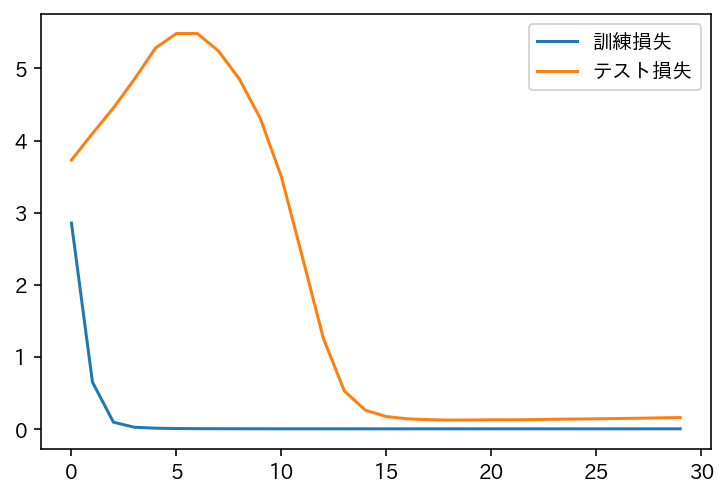

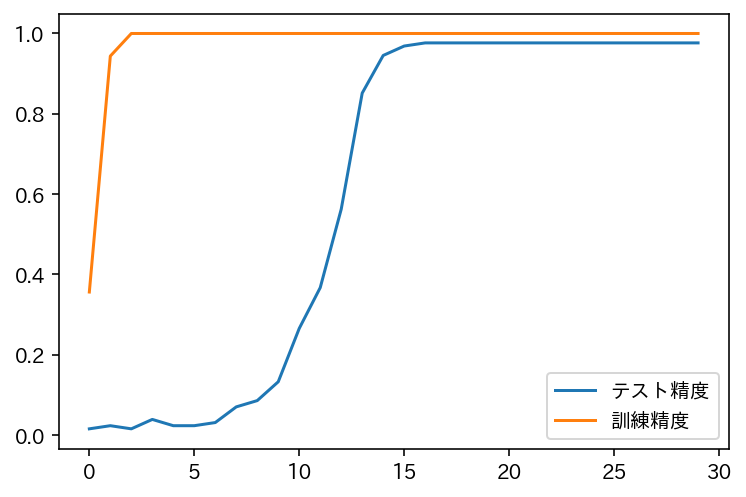

In [19]:
# 学習進行状況の描画
plt.plot(train_losses, label='訓練損失')
plt.plot(test_losses, label='テスト損失')
plt.legend()
plt.show()

plt.plot(test_accs, label="テスト精度")
plt.plot(train_accs, label="訓練精度")
plt.legend()
plt.show()         